In [1]:
import numpy as np
import awkward as ak
import fastjet
import uproot4 as ur
import matplotlib.colors as mcolors
import mplhep as hep
import matplotlib.pyplot as plt
import math
import matplotlib as colors
import matplotlib as abc
from scipy.optimize import curve_fit
import pandas as pd
from iminuit import Minuit
from iminuit.cost import LeastSquares

hep.style.use(hep.style.CMS)
hep.style.use("CMS")
plt.rcParams['figure.facecolor']='white'
plt.rcParams['savefig.facecolor']='white'
plt.rcParams['savefig.bbox']='tight'

In [2]:
input_file = 'SimpleTree_mudst_pythia.root'
events = ur.open("%s:data"%(input_file))
arrays = events.arrays()

posx = arrays['Cal_hit_posx']
posy = arrays['Cal_hit_posy']
posz = arrays['Cal_hit_posz']
energy = arrays['Cal_hit_energy']
detid = arrays['Cal_detid']

adcsum = arrays['Cal_adcsum']
detid = arrays['Cal_detid']

cut_primary = (arrays['Cal_hit_energy']>0.1) & ((arrays['Cal_detid']==0) ^(arrays['Cal_detid']==1) ^ (arrays['Cal_detid']==2) ^ (arrays['Cal_detid']==3))
cut_HCAL = (arrays['Cal_hit_energy']>0.1) & ((arrays['Cal_detid']==2) ^ (arrays['Cal_detid']==3))
cut_ECAL = (arrays['Cal_hit_energy']>0.1) & ((arrays['Cal_detid']==0) ^ (arrays['Cal_detid']==1))

xcut = posx[cut_primary]
ycut = posy[cut_primary]
zcut = posz[cut_primary]
ecut = energy[cut_primary]
idcut = detid[cut_primary]

xHcal = posx[cut_HCAL]
yHcal = posy[cut_HCAL]
zHcal = posz[cut_HCAL]
eHcal = energy[cut_HCAL]

xEcal = posx[cut_ECAL]
yEcal = posy[cut_ECAL]
zEcal = posz[cut_ECAL]
eEcal = energy[cut_ECAL]

In [3]:
norms = np.sqrt(xcut**2 + ycut**2 + zcut**2)
px = (xcut / norms) * ecut
py = (ycut / norms) * ecut
pz = (zcut / norms) * ecut
ex = np.abs(px)

momenta = ak.zip(
    {
        "px": ak.Array(px),
        "py": ak.Array(py),
        "pz": ak.Array(pz),
        "E": ak.Array(ecut),
        "det": ak.Array(idcut)
    }
)

allLorentz = ak.Array(momenta, with_name="Momentum4D", behavior=ak.behavior)

print(allLorentz)

[[{px: -0.14, py: 0.0828, pz: 2.36, E: 2.37, det: 0}, ..., {px: ..., ...}], ...]


In [4]:
# Define the jet definition
jetdef = fastjet.JetDefinition(fastjet.antikt_algorithm, 1.0)

# Cluster the particles into jets
cluster = fastjet.ClusterSequence(allLorentz, jetdef)
inc_jets = cluster.inclusive_jets()

# Define a function to calculate the x, y, and z components of the momentum vector
def momentum_xyz(px, py, pz):
    norm = np.sqrt(px**2 + py**2 + pz**2)
    x = px / norm
    y = py / norm
    z = pz / norm
    return x, y, z

# Define a function to calculate the eta coordinate
def eta(r, z):
    theta = abs(np.arctan(r / z))
    result = np.where(z < 0, np.log(np.tan(theta / 2)), -1 * np.log(np.tan(theta / 2)))
    return result

def inverse_eta(eta, z):
    y = z * (2 * np.exp(-eta)) / (1 - np.exp(-2*eta))
    return y

def phi(x,y):
    return np.arctan2(y, x)

In [5]:
input_file = 'pythia8.starsim.root'
events = ur.open("%s:genevents/primaryEvent/mParticles"%(input_file))
arrays = events.arrays()

cut_primary = (arrays['mParticles.mStatus'] == 1)

energy = arrays['mParticles.mEnergy'][cut_primary]
status = arrays['mParticles.mStatus'][cut_primary]
Px = arrays['mParticles.mPx'][cut_primary]
Py = arrays['mParticles.mPy'][cut_primary]
Pz = arrays['mParticles.mPz'][cut_primary]

In [6]:
Gmomenta = ak.zip(
    {
        "px": ak.Array(Px),
        "py": ak.Array(Py),
        "pz": ak.Array(Pz),
        "E": ak.Array(energy),

    }
)

GallLorentz = ak.Array(Gmomenta, with_name="Momentum4D", behavior=ak.behavior)

print(GallLorentz)

[[{px: 2.11, py: 0.8, pz: -0.698, E: 2.36}, ..., {px: -0.0573, ...}], ...]


In [9]:
# Define the jet definition
jetdef = fastjet.JetDefinition(fastjet.antikt_algorithm, 1.0)

# Cluster the particles into jets
Gcluster = fastjet.ClusterSequence(GallLorentz, jetdef)
Ginc_jets = Gcluster.inclusive_jets()

# Extract the x, y, and z components of the momentum vector
jetX, jetY, jetE = [], [], []
jetXAll, jetYAll, jetEAll, jetEta = [], [], [], []


x, y, z = momentum_xyz(Ginc_jets.px, Ginc_jets.py, Ginc_jets.pz)
    
jetE = Ginc_jets.E
jetXH = 806 * x / z
jetYH = 806 * y / z

jetXE = 724 * x / z
jetYE = 724 * y / z

jetEta = eta(np.sqrt(x**2 + y**2), z)
print(jetEta)
jetPhi = phi(x,y)

cut_secondary = (jetEta > 2.4) & (jetE > 10)

jetE = jetE[cut_secondary]
jetXH = jetXH[cut_secondary]
jetYH = jetYH[cut_secondary]

jetXE = jetXE[cut_secondary]
jetYE = jetYE[cut_secondary]
jetEta = jetEta[cut_secondary]
jetPhi = jetPhi[cut_secondary]

[[5.36, -5.17, 4.47, -1.3, -4.66, ..., 2.22, -2.25, -0.369, 2.94, -0.413], ...]


Text(0.5, 1.0, 'Gen Jet Multiplicity')

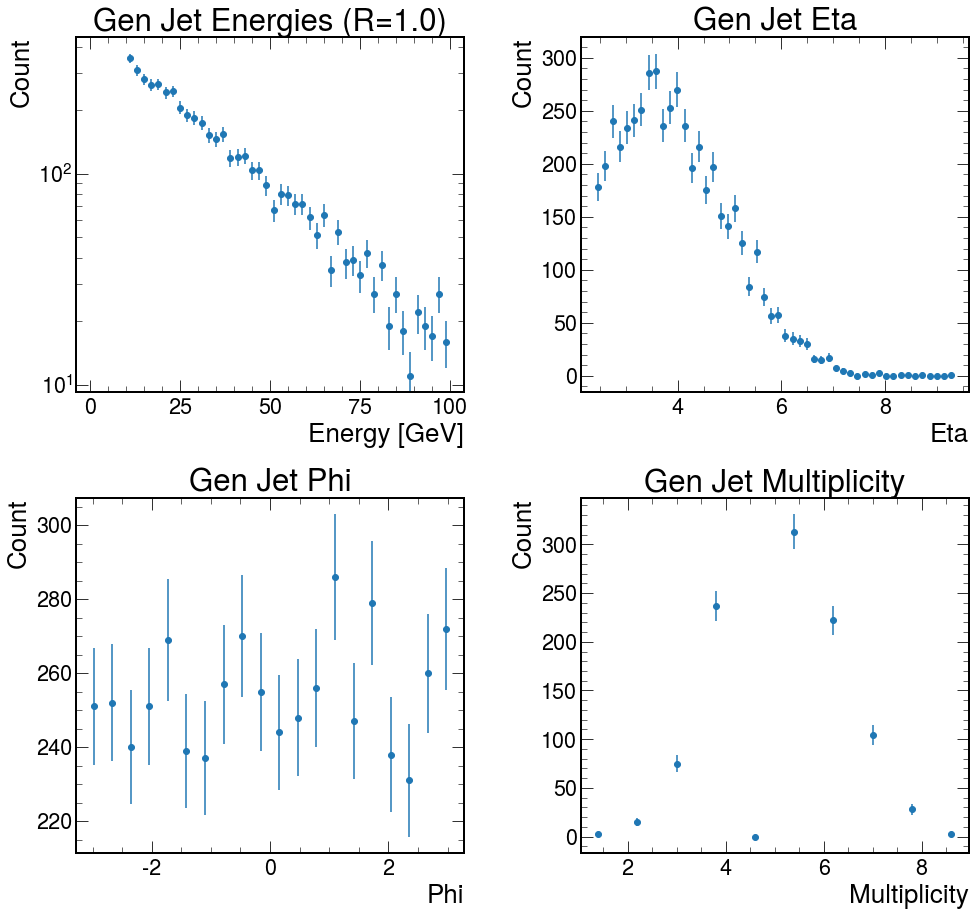

In [10]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(16, 15), gridspec_kw={'wspace': 0.3,'hspace': 0.3})

plt.sca(axs[0][0])


hist, bin_edges = np.histogram(ak.flatten(jetE),range=(0,100),bins=50)
   
bin_centres = (bin_edges[:-1] + bin_edges[1:])/2

plt.errorbar(np.array(bin_centres),np.array(hist),yerr=np.sqrt(hist),fmt="o")
plt.yscale("log")
plt.xlabel('Energy [GeV]')
plt.ylabel('Count')
plt.title("Gen Jet Energies (R=1.0)")

plt.sca(axs[0][1])


hist, bin_edges = np.histogram(ak.flatten(jetEta),bins=50)
   
bin_centres = (bin_edges[:-1] + bin_edges[1:])/2

plt.errorbar(np.array(bin_centres),np.array(hist),yerr=np.sqrt(hist),fmt="o")

plt.xlabel('Eta')
plt.ylabel('Count')
plt.title("Gen Jet Eta")


plt.sca(axs[1][0])


hist, bin_edges = np.histogram(ak.flatten(jetPhi),bins=20)
   
bin_centres = (bin_edges[:-1] + bin_edges[1:])/2

plt.errorbar(np.array(bin_centres),np.array(hist),yerr=np.sqrt(hist),fmt="o")

plt.xlabel('Phi')
plt.ylabel('Count')
plt.title("Gen Jet Phi")

def get_multiplicity(data):
    return ak.Array([len(subarray) for subarray in data])

plt.sca(axs[1][1])


hist, bin_edges = np.histogram(get_multiplicity(jetE))
   
bin_centres = (bin_edges[:-1] + bin_edges[1:])/2

plt.errorbar(np.array(bin_centres),np.array(hist),yerr=np.sqrt(hist),fmt="o")

plt.xlabel('Multiplicity')
plt.ylabel('Count')
plt.title("Gen Jet Multiplicity")